# qPCR Data Analysis Notebook


- This notebook extracts data from Applied Biosystems qPCR results spreadsheets and proceeds to calculate 2^-dCT and 2^-ddCT.
- User input of folder path, target genes, housekeeping gene, and control sample (for 2^-ddCT).
- The script filters out outliers that are >1 away from the technical replicate median.
- Notebook should run in virtual environment with the packages and package versions stated in the .yaml file.

## 1. Import libraries and modules
- Do not install entire libraries every time your notebook - these will already be installed in the conda environment.
- Do import modules every time you open notebook - these are wiped between sessions.

In [4]:
# check what libraries are installed in conda environment
!conda list

# packages in environment at /opt/anaconda3/envs/data_analysis:
#
# Name                    Version                   Build  Channel
absl-py                   2.1.0                    pypi_0    pypi
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
astunparse                1.6.3                    pypi_0    pypi
bzip2                     1.0.8                h6c40b1e_6  
ca-certificates           2024.7.4             h8857fd0_0    conda-forge
certifi                   2024.7.4                 pypi_0    pypi
charset-normalizer        3.3.2                    pypi_0    pypi
comm                      0.2.2              pyhd8ed1ab_0    conda-forge
contourpy                 1.2.1                    pypi_0    pypi
cycler                    0.12.1                   pypi_0    pypi
debugpy                   1.8.3           py312h28f332c_0    conda-forge
decorator                 5.1.1              p

In [161]:
from matplotlib import pyplot as plt 
import pandas as pd
import numpy as np
import scipy as sp 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import glob
import xlrd
from pathlib import Path
import os

## 2. Import qPCR data
- Imports data from spreadsheet exported from Applied Biosystem machine.
- Only imports 'Sample Name', 'Target Name', and 'CT'.
- Concatenates all spreadsheets within path folder to form one combined pandas dataframe.
- Drops 'NaN' and 'Undetermined' CT values.
- Extracts timepoint and culture condition from sample name 
    - e.g. from '138 ALG D1 STATIC' extracts 'D1' and 'STATIC' and indents into new collumns for timepoint and culture conditions.

In [31]:
# We want to dispaly all rows of data frame rather than truncated version so we can confirm it contains all data
# To display all rows
pd.set_option('display.max_rows', None)

# To display all columns
pd.set_option('display.max_columns', None)

In [79]:
# State folder path containing qPCR spreadsheets
folder_path_str = r'/Users/frasershields/Library/CloudStorage/OneDrive-TheUniversityofManchester/PhD/Coding/qPCR_notebook'


# read excel file into dataframe, for qPCR data - header start at row 8 (0-indexing, thus index of 7)
all_files = glob.glob(folder_path_str + "/*.xls")
li = []
for filename in all_files:
    df = pd.read_excel(filename, sheet_name='Results', header=7)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

# create new dataframe with only desirable collumn data
# want sample name, gene target name and CT value
# indexing multiple collumns required double square brackets
df = df[['Sample Name', 'Target Name', 'Cт']]

# rename the CT collumn header as it uses strange symbol for CT, requiring us to copy and paste. Therefore lets change it to CT.
# inplace = True means the dataframe is renamed in place rather than returning a copy when inplace = False, which is the default. if we used the latter we would require df = df.rename() to replace our dataframe with the new copy
df.rename(columns = {'Cт':'CT'}, inplace = True)

# drops rows with NaN
df = df.dropna()

# Create new dataframe taking all rows without 'undetermined' string
# in Ct collumn using boolean indexing
# In boolean indexing, we will select subsets of data based on the actual
# values of the data in the DataFrame and not on their row/column labels or integer locations.
# In boolean indexing, we use a boolean vector to filter the data
#
# Boolean data type = a form of data with only two possible values e.g. True or False
# Create boolean mask
mask = df['CT'] != 'Undetermined'
# Apply mask to filter out rows containing string
df = df[mask]

# convert ct collumn to numerical values so we can perform aggregate and statistical operations later
df['CT'] = pd.to_numeric(df['CT'])

# Group df by sample name and target gene name
# use agg() function to perform aggregate operations to data e.g. mean, std, sum, count etc.
# Grouping by several collumns results in a dataframe with multi-index (aka hierachihcal index)
grouped_df = df.groupby(['Sample Name', 'Target Name'])


In [80]:
# Detect outliers using 1.5 x IQR rule
# first calculate Q1 and Q3 of grouped data using quantile function from numpy package
# the quantile is worked out based on rank order of values e.g. 0.5 quantile = median
# pandas automatically applies any function, i.e. quantile(), to each group seperately within a grouped dataframe
# This behaviour is inherent to 'groupby()' functionality in panda

Q1 = grouped_df['CT'].quantile(0.25)
Q3 = grouped_df['CT'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bound for outlier detection using 1.5 X IQR rule
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers from each group
# This code uses the apply() function which allows you to apply a function along an axis of a dataframe or series
# this can be useful for aggregating and transforming data
# the function applies is a lambda function, aka anonymous function, which are small, inline functions defined without a name
# lambda functions are useful when you need a simple function for a short period of time e.g. for one line of code
# In this code lambda function takes one argument 'x' representing the grouped dataframe its being iterated over
# x['Ct'] indexes the Ct collumn from the grouped dataframe
# this codes only keeps data which is between lower and upper bound, filtering out other data with a boolean mask
# x.name represents the name of each group i.e. a tuple containing 'Sample Name' and'Target Name'
# Using x.name allows you to calculate the lower and upper bounds specific to each group, ensuring that outliers are determined based on the quartiles and IQR of each individual group's 'CT' values.
filtered_groups = grouped_df.apply(lambda x: x[(x['CT'] >= lower_bound[x.name]) & (x['CT'] <= upper_bound[x.name])], include_groups=False)

# Iterate through each group in the DataFrame
# need to groupby() again as we have applied a function to the previously grouped object, thus resulting in
# a combined data frame (split-apply-combine)
for group_key, group in filtered_groups.groupby(['Sample Name', 'Target Name']):

    # Get the number of samples within the group
    num_value = len(group)

    # state threshold value
    threshold = 1

    # If only one CT value is present, remove it
    # .loc() allows us ot access a group of rows and collumns by the labels being looped
    if num_value == 1:
        filtered_groups.loc[group_key] = None
    elif num_value == 2:
        # If 2 CT values are present, check that the absolute difference between them is less than threshold apart
        diff = np.abs(group['CT'].values[0] - group['CT'].values[1])
        # if the differece is above threshold, remove both CT value
        if diff > threshold:
            filtered_groups.loc[group_key] = None
    else:
        # for 3 CT values, work out the median and remove CT value than are greater than threshold away from median
        median_ct = np.median(group['CT'].values)
        diff = np.abs(group['CT'].values - median_ct)
        # check if any of the calculates diffrences beween ct and median are above threshold and remove CT values that are above threshold
        if np.any(diff > threshold):
            group = group[diff <= threshold]
        # if all CT values are more than threshold apart from median, remove them all
        elif np.all(diff > threshold):
            filtered_groups.loc[group_key] = None

        # update original dataframe with the modified group
        filtered_groups.loc[group_key] = group

# drop NaN values from filtered groups
filtered_groups = filtered_groups.dropna()

print(filtered_groups)
## This section of the for loop calculates 2^-dCT for each datafram

# first we calculate the mean CT values for each sample and target gene by grouping the data and using mean function
CT_mean = filtered_groups.groupby(['Sample Name', 'Target Name'])['CT'].mean()

# We can now reset the index of the dataframe so that the levels 'Sample Name' 'Target Nmae' now become collumn headers again. As our CT collumn now only contains one value, this makes it easier to index out data when calculating dCT and ddCT
CT_mean = CT_mean.reset_index()

print(CT_mean)

                                      CT
Sample Name   Target Name               
137 400 D1 S  COL1A2      3    37.020802
                          4    35.993385
                          5    36.280266
              YWHAZ       99   30.253641
                          100  30.530331
                          101  31.094831
137 400 D14 S COL1A2      12   16.322466
                          13   16.238863
                          14   16.296181
              YWHAZ       108  21.869707
                          109  21.777222
                          110  21.726078
137 400 D28 D COL1A2      21   15.366911
                          22   15.404736
                          23   15.496473
              YWHAZ       117  20.529758
                          118  20.545515
                          119  20.641731
137 400 D28 S COL1A2      24   15.505604
                          25   15.501820
                          26   15.424093
              YWHAZ       120  20.621885
                

In [81]:
# We want to create new collumns in the dataframe stating timepoint and culture conditions 
# Split the 'Sample Name' column into multiple columns
split_columns = CT_mean['Sample Name'].str.split(' ', expand=True)

# Assign the split parts to new columns with appropriate names
CT_mean['Biological Replicate'] = split_columns[0]
CT_mean['Reinforcement'] = split_columns[1]
CT_mean['Timepoint'] = split_columns[2]
CT_mean['Culture Conditions'] = split_columns[3]

# Drop the original 'Sample Name' column if no longer needed
CT_mean_split = CT_mean.drop(columns=['Sample Name'])

print(CT_mean_split)

   Target Name         CT Biological Replicate Reinforcement Timepoint  \
0       COL1A2  36.431484                  137           400        D1   
1        YWHAZ  30.626268                  137           400        D1   
2       COL1A2  16.285837                  137           400       D14   
3        YWHAZ  21.791002                  137           400       D14   
4       COL1A2  15.422707                  137           400       D28   
5        YWHAZ  20.572335                  137           400       D28   
6       COL1A2  15.477172                  137           400       D28   
7        YWHAZ  20.545431                  137           400       D28   
8       COL1A2  19.272138                  137           800        D1   
9        YWHAZ  20.784946                  137           800        D1   
10      COL1A2  16.154617                  137           800       D14   
11       YWHAZ  21.449211                  137           800       D14   
12      COL1A2  14.993671             

## 3. Calculating dCT, ddCT, 2^-dCT and 2^-ddCT

In [137]:
# Assuming CT_mean_split is your DataFrame
# CT_mean_split has columns: 'Target Name', 'CT', 'Biological Replicate', 'Reinforcement', 'Timepoint', 'Culture Conditions'

# Input for housekeeping gene and control sample criteria
housekeeping_gene = input("Enter the housekeeping gene: ")  # Example: 'YWHAZ'
control_reinforcement = input("Enter the control reinforcement (e.g., 'Alg' for Alginate): ")  # Example: 'Alg'
control_timepoint = input("Enter the control timepoint (e.g., 'D1'): ")  # Example: 'D1'

In [138]:
# Step 1: Calculate dCT
# Pivot the DataFrame to have target names as columns
pivot_df = CT_mean_split.pivot_table(index=['Biological Replicate', 'Reinforcement', 'Timepoint', 'Culture Conditions'], 
                                     columns='Target Name', values='CT').reset_index()


# Calculate dCT for each sample (target gene - housekeeping gene)
# First we need to create a list containing target gen names
# We subtract the housekeeping gene's CT from each target gene's CT
target_genes = [col for col in pivot_df.columns if col not in ['Biological Replicate', 'Reinforcement', 'Timepoint', 'Culture Conditions', housekeeping_gene]]
for gene in target_genes:
    pivot_df[f'dCT {gene}'] = pivot_df[gene] - pivot_df[housekeeping_gene]

# print(target_genes)
# print(pivot_df)
# pivot_df['dCT'] = pivot_df.apply(lambda row: row.drop(['Biological Replicate', 'Reinforcement', 'Timepoint', 'Culture Conditions', housekeeping_gene]).values - row[housekeeping_gene], axis=1)


# Step 2: Identify control group based on user input
control_group = pivot_df[(pivot_df['Reinforcement'] == control_reinforcement) & 
                         (pivot_df['Timepoint'] == control_timepoint)]
                        

# Step 3: Calculate ddCT, 2^-dCT and 2^-ddCt and output results dataframe

# Initialize an empty DataFrame to store results
results_df = pivot_df.copy()

# Loop through each target gene
for gene in target_genes:
    # Calculate the mean dCT for the control group for the current gene
    control_dCT = control_group.groupby('Biological Replicate')[f'dCT {gene}'].mean().reset_index()
    control_dCT.columns = ['Biological Replicate', f'Control dCT {gene}']

    # Merge the control dCT values with the main DataFrame
    merged_df = pd.merge(results_df, control_dCT, on='Biological Replicate', how='left')

    # Calculate ddCT (ΔCT_sample - ΔCT_control)
    merged_df[f'ddCT {gene}'] = merged_df[f'dCT {gene}'] - merged_df[f'Control dCT {gene}']

    # Calculate 2^-dCT and 2^-ddCT
    merged_df[f'2^-dCT {gene}'] = 2 ** (-merged_df[f'dCT {gene}'])
    merged_df[f'2^-ddCT {gene}'] = 2 ** (-merged_df[f'ddCT {gene}'])
    
    # Update results_df to include the new columns
    results_df = merged_df



# Display the resulting DataFrame
print(results_df)

# Input results folder path
results_folder_path= '/Users/frasershields/Library/CloudStorage/OneDrive-TheUniversityofManchester/PhD/Coding/qPCR_notebook'

# Input results file name
file_name = 'results.csv'
full_file_path = results_folder_path + '/' + file_name

# Save the DataFrame to the specified path
results_df.to_csv(full_file_path, index=False)

   Biological Replicate Reinforcement Timepoint Culture Conditions     COL1A2  \
0                   137           400        D1                  S  36.431484   
1                   137           400       D14                  S  16.285837   
2                   137           400       D28                  D  15.422707   
3                   137           400       D28                  S  15.477172   
4                   137           800        D1                  S  19.272138   
5                   137           800       D14                  S  16.154617   
6                   137           800       D28                  D  14.993671   
7                   137           800       D28                  S  15.272313   
8                   137           Alg        D1                  S  17.955828   
9                   137           Alg       D14                  S  17.620342   
10                  137           Alg       D28                  S  16.513692   
11                  164     

## 4. Plot Results
- Using matplotlib and seaborne


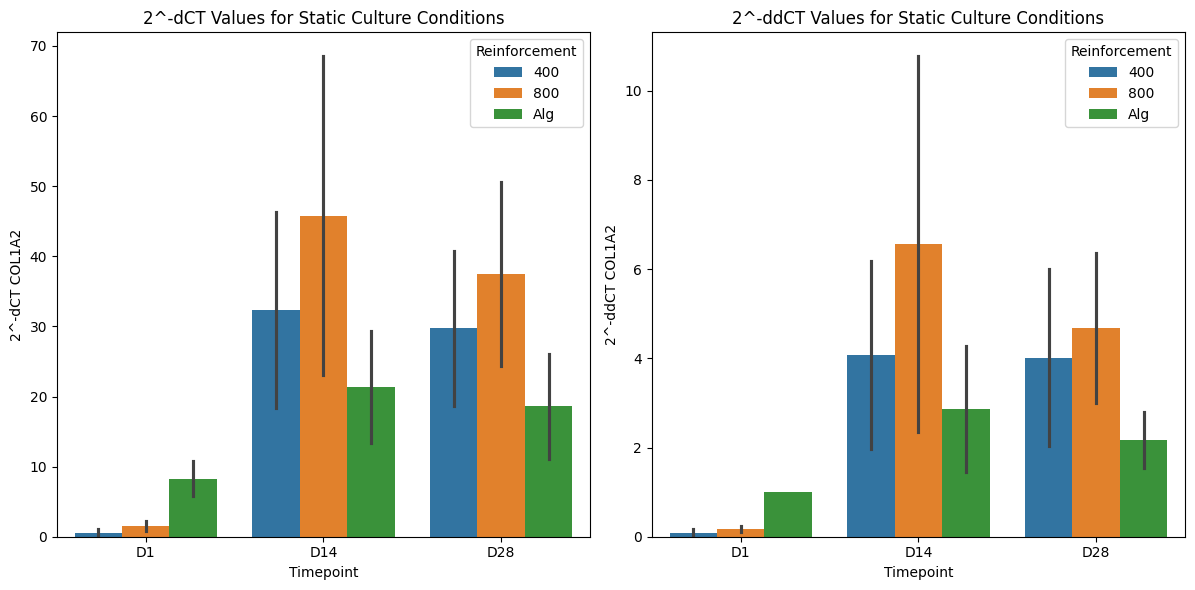

ANOVA for Static Culture Conditions:
                      sum_sq    df         F    PR(>F)
C(Reinforcement)   14.655746   2.0  0.782507  0.469575
C(Timepoint)       82.883062   2.0  4.425335  0.024252
Residual          206.021406  22.0       NaN       NaN

Tukey's HSD Test for Static Culture Conditions:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower    upper  reject
-------------------------------------------------------------
 400 at D1 400 at D14    3.972 0.8387  -5.2651 13.2091  False
 400 at D1 400 at D28   3.9195 0.8477  -5.3176 13.1566  False
 400 at D1  800 at D1   0.0749    1.0  -9.1622   9.312  False
 400 at D1 800 at D14   6.4712 0.3142  -2.7659 15.7083  False
 400 at D1 800 at D28   4.5814  0.718  -4.6557 13.8185  False
 400 at D1  Alg at D1   0.9056    1.0  -8.3315 10.1427  False
 400 at D1 Alg at D14    2.769 0.9746  -6.4681 12.0061  False
 400 at D1 Alg at D28   2.0759 0.9959  -7.1612  11.313  False
400 at D14 4

In [170]:
# First lets plot all rienforcement and timepoints under static condtions

# Step 1: Filter the data for static culture conditions
df_static = results_df[results_df['Culture Conditions'] == 'S']

# Step 2: Plot the bar chart for 2^-dCT values
# Create bar plots
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.barplot(data=df_static, x='Timepoint', y='2^-dCT COL1A2', hue='Reinforcement', errorbar="se")
plt.title('2^-dCT Values for Static Culture Conditions')
plt.ylabel('2^-dCT COL1A2')
plt.legend(title='Reinforcement')

# Step 3: Plot the bar chart for 2^-ddCT values
plt.subplot(1, 3, 2)
sns.barplot(data=df_static, x='Timepoint', y='2^-ddCT COL1A2', hue='Reinforcement', errorbar="se")
plt.title('2^-ddCT Values for Static Culture Conditions')
plt.ylabel('2^-ddCT COL1A2')
plt.legend(title='Reinforcement')


plt.tight_layout()
plt.show()

# Perform two-way ANOVA analysis 

model_static = ols('values ~ C(Reinforcement) * C(Timepoint)', 
                   data={'values': df_static['2^-ddCT COL1A2'], 
                         'Reinforcement': df_static['Reinforcement'], 
                         'Timepoint': df_static['Timepoint']}).fit()
anova_static = sm.stats.anova_lm(model_static, typ=2)

print("ANOVA for Static Culture Conditions:")
print(anova_static)

mc_static = pairwise_tukeyhsd(endog=df_static['2^-ddCT COL1A2'], 
                              groups=df_static['Reinforcement'] + ' at ' + df_static['Timepoint'],
                              alpha=0.05)
print("\nTukey's HSD Test for Static Culture Conditions:")
print(mc_static.summary())

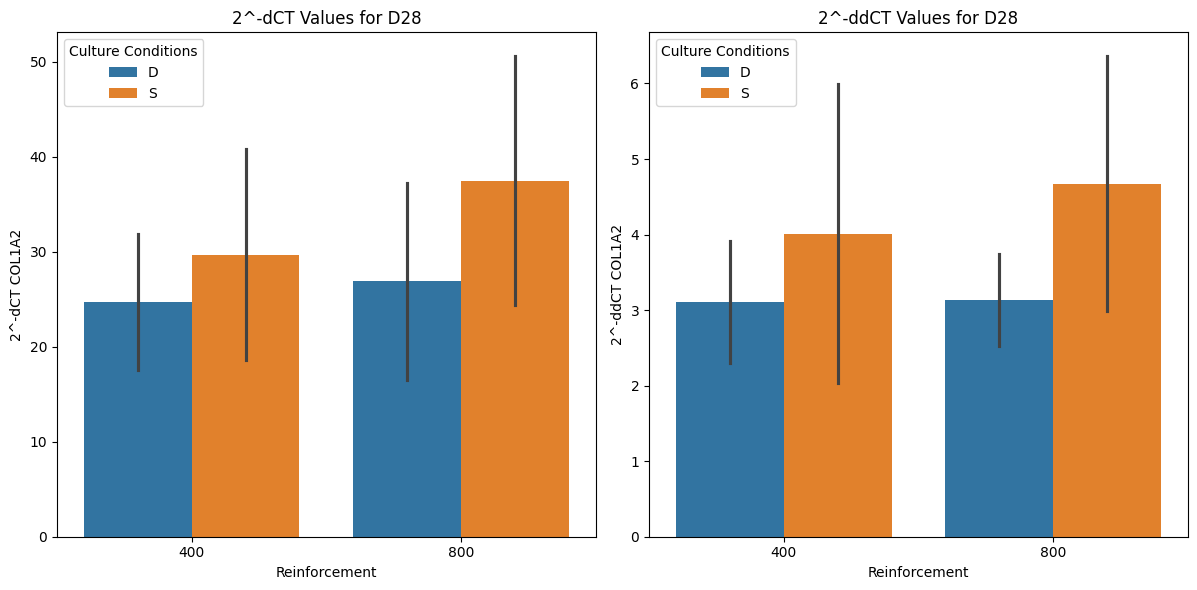

SyntaxError: invalid syntax (<unknown>, line 1)

In [169]:
# Second lets just plot the last timepoint, comparing static and dynamic culture conditions

# Step 1: Filter the data for static culture conditions
df_end_timepoint = results_df[(results_df['Timepoint'] == 'D28') & (results_df['Reinforcement'].isin(['400', '800']))]


# Step 2: Plot the bar chart for 2^-dCT values
# Create bar plots
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.barplot(data=df_end_timepoint, x='Reinforcement', y='2^-dCT COL1A2', hue='Culture Conditions', errorbar="se")
plt.title('2^-dCT Values for D28')
plt.ylabel('2^-dCT COL1A2')
plt.legend(title='Culture Conditions')

# Step 3: Plot the bar chart for 2^-ddCT values
plt.subplot(1, 3, 2)
sns.barplot(data=df_end_timepoint, x='Reinforcement', y='2^-ddCT COL1A2', hue='Culture Conditions', errorbar="se")
plt.title('2^-ddCT Values for D28')
plt.ylabel('2^-ddCT COL1A2')
plt.legend(title='Culture Conditions')


plt.tight_layout()
plt.show()

# Perform Two-Way ANOVA for the last timepoint
model_last_timepoint = ols('values ~ C(Reinforcement) * C(Culture Conditions)', 
                           data={'values': df_end_timepoint['2^-ddCT COL1A2'], 
                                 'Reinforcement': df_end_timepoint['Reinforcement'], 
                                 'Culture Conditions': df_end_timepoint['Culture Conditions']}).fit()
anova_last_timepoint = sm.stats.anova_lm(model_last_timepoint, typ=2)

print("ANOVA for Last Timepoint (D28):")
print(anova_last_timepoint)

# Perform Tukey's HSD test for multiple comparisons
mc_last_timepoint = pairwise_tukeyhsd(endog=df_end_timepoint['2^-ddCT COL1A2'], 
                                      groups=df_end_timepoint['Reinforcement'] + ' in ' + df_end_timepoint['Culture Conditions'],
                                      alpha=0.05)

print("\nTukey's HSD Test for Last Timepoint (D28):")
print(mc_last_timepoint.summary())
